# Statistics of wiki http requests data
#### This note book needs `.json` (time series) and `.txt` (corresponding wiki project name) as input.


In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
# important window definition

prediction_length = 48
context_length = 72
day = 24
week = 148
month = 720
year = 8760

#### Prepare the time series for the following analysis.

In [3]:
# get the Time Series data and corresponding wiki project name
def get_ts(data_location,label_location,freq):
    df_ts = pd.read_json(data_location, lines=True)
    num_pt = min(len(df_ts.iloc[1, 1]), 100000)
    print('use first ', num_pt, ' points in a time series')
    num_ts = len(df_ts)

    time_series_wiki = []
    for k in range(num_ts):
        t0 = df_ts.iloc[k, 0]
        data = df_ts.iloc[k, 1][:num_pt]
        index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
        time_series_wiki.append(pd.Series(data=data, index=index))
        
    with open(label_location) as f:
        wp_list = f.read().splitlines()  
        
    return time_series_wiki, wp_list

#### Generate the time series, straight up plot some of them to get a general idea.

In [4]:
label_location = 'wp_full-20160101-20180101_get.txt'    
data_location = 'train_2year.json'
#data_location = "s3://{}/test/test.json".format(s3_data_path)
freq = 'H'

time_series_wiki, wp_list = get_ts(data_location,label_location,freq)

use first  17568  points in a time series


545


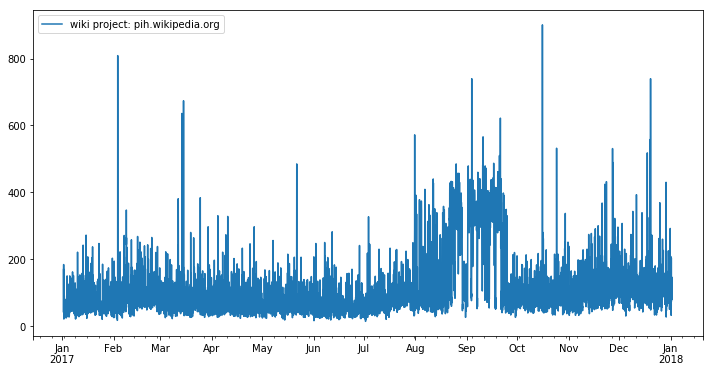

515


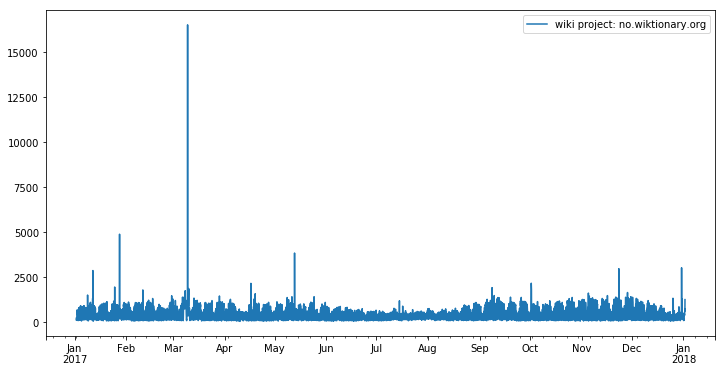

703


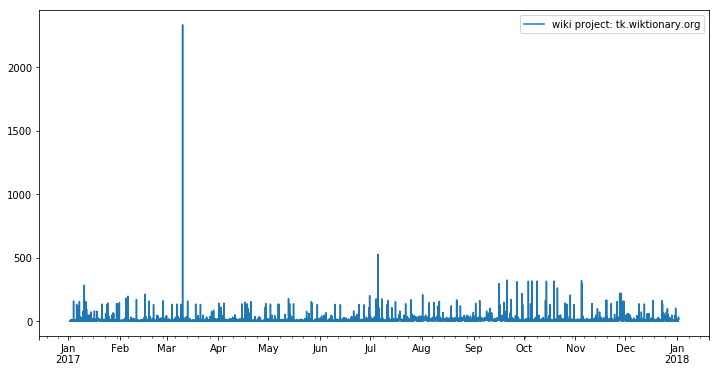

329


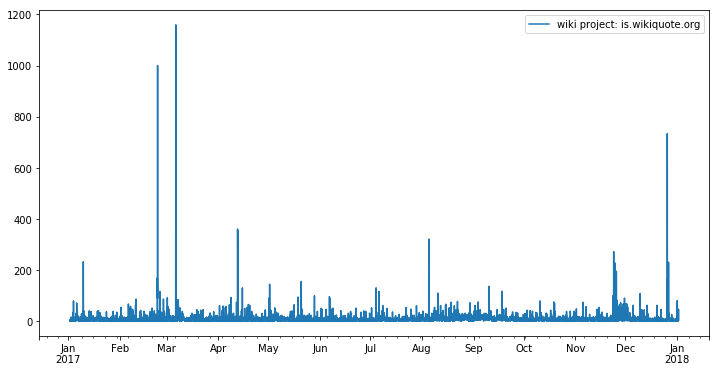

149


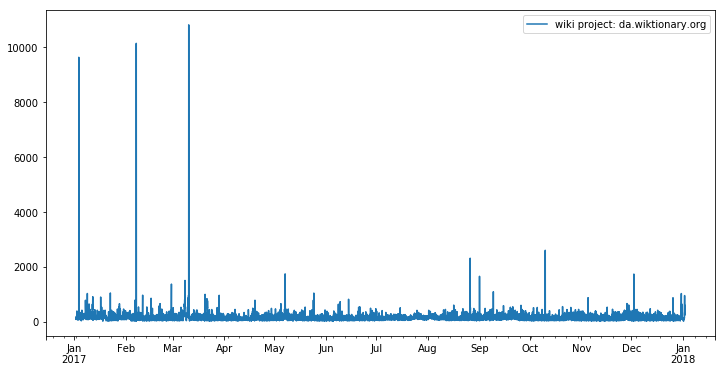

221


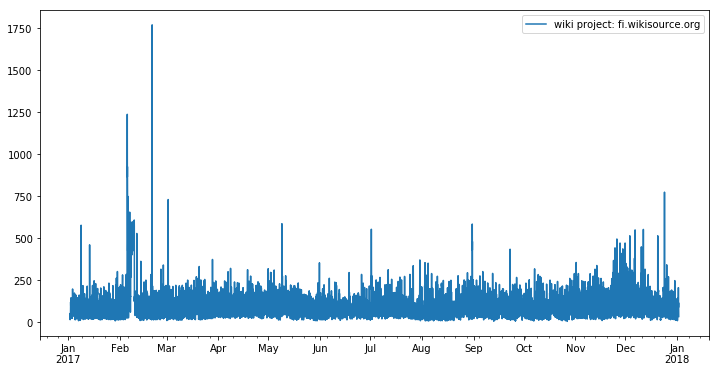

186


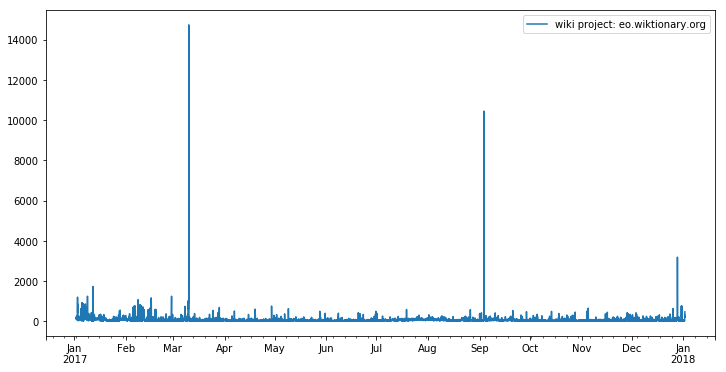

403


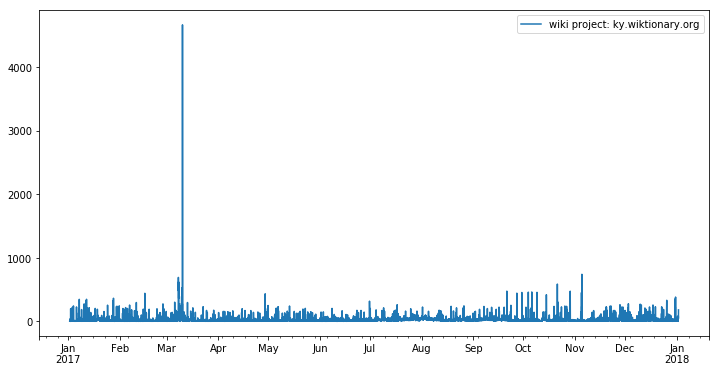

326


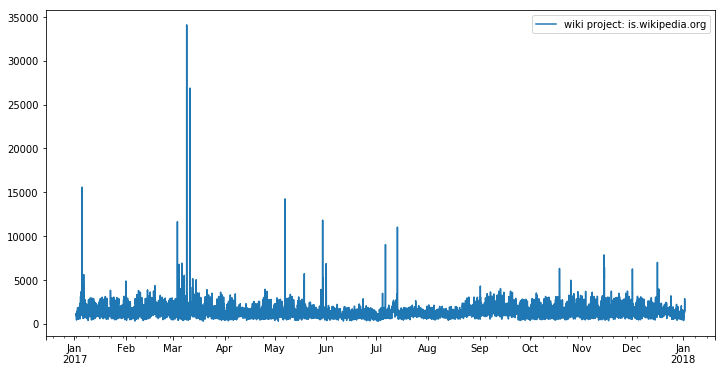

133


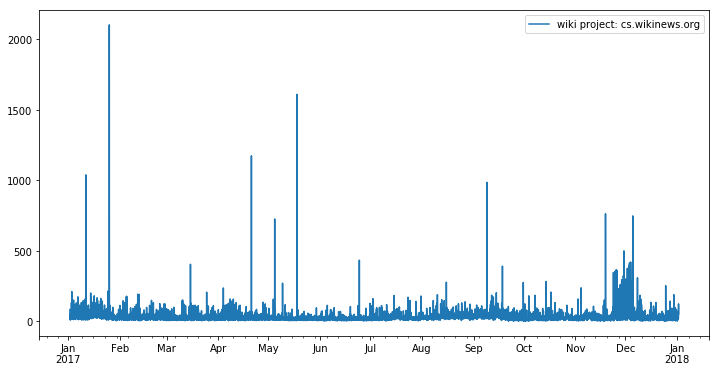

333


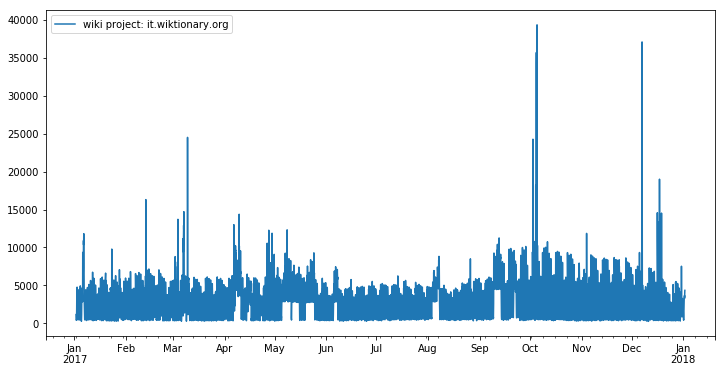

219


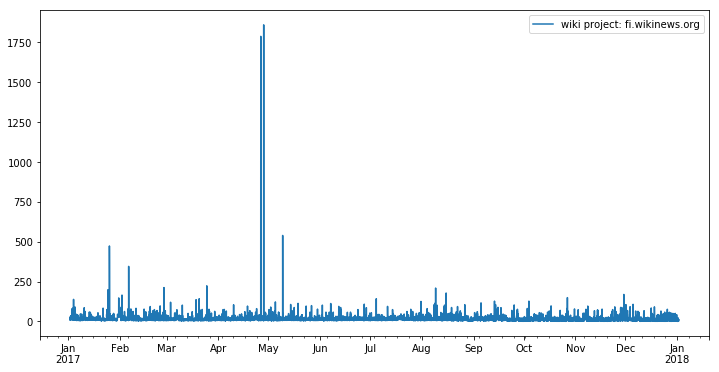

151


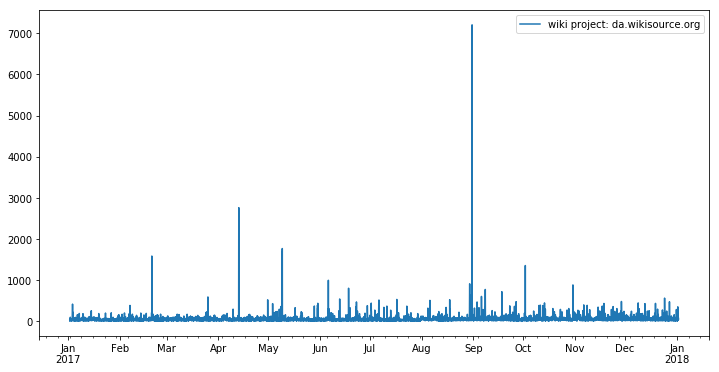

465


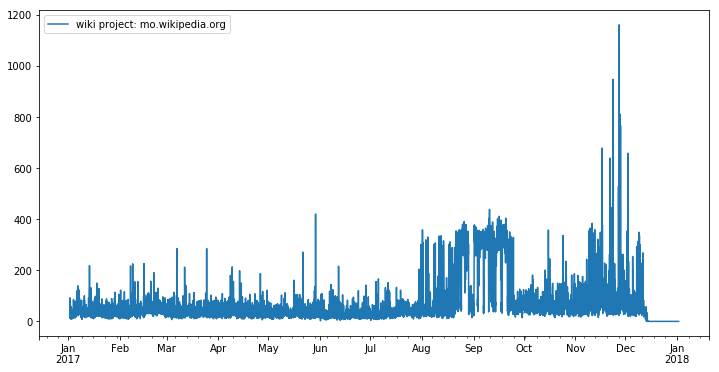

609


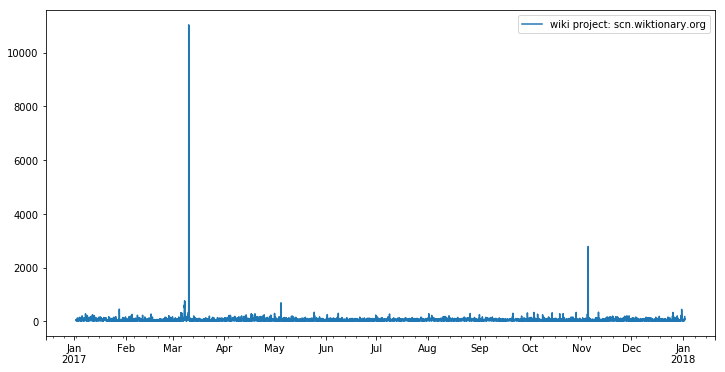

240


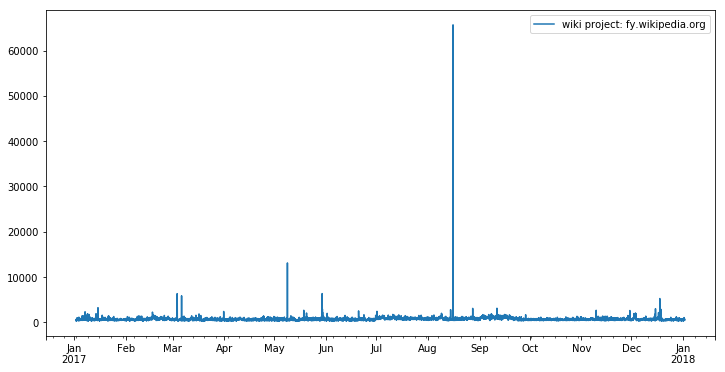

351


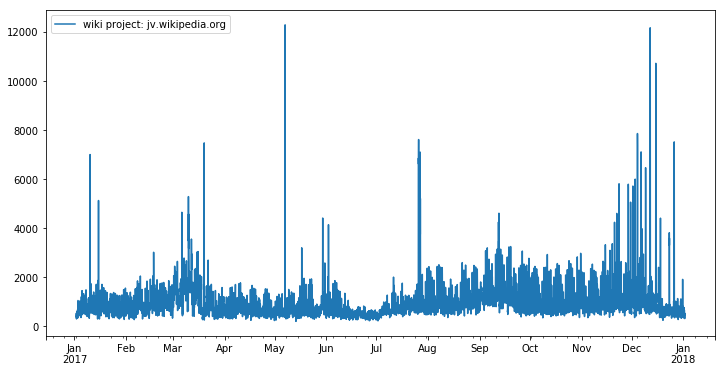

46


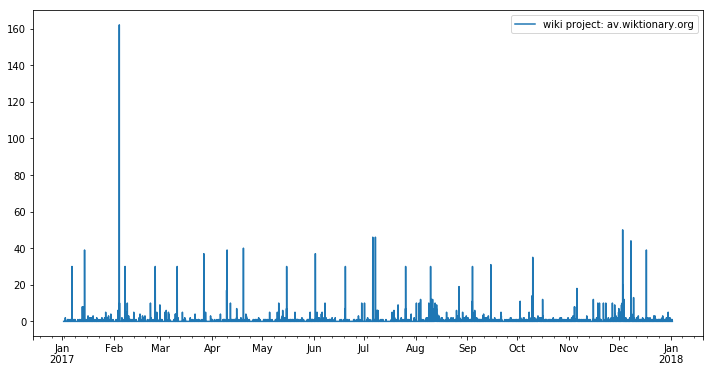

301


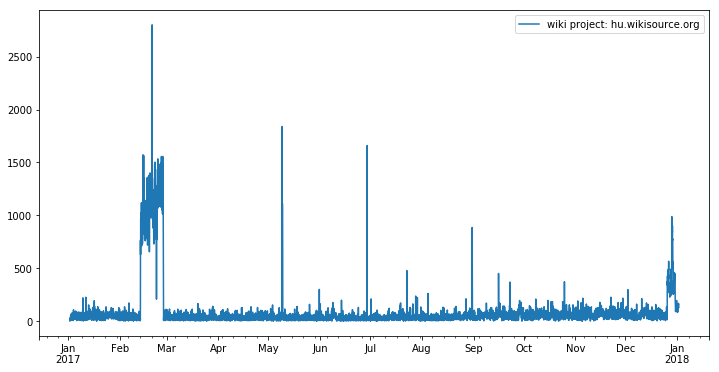

289


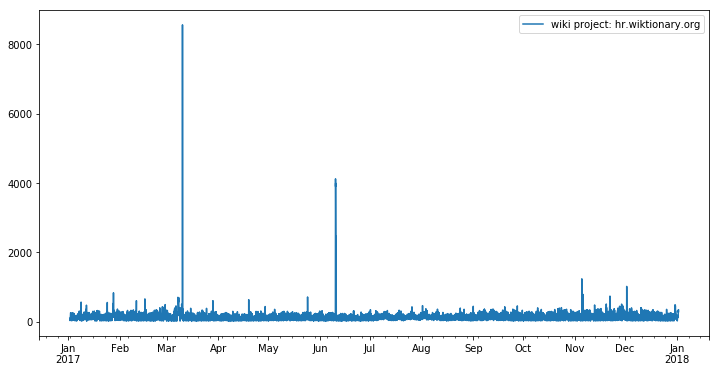

In [5]:
# plot some data
for k in np.random.randint(low=0, high=len(time_series_wiki)-1, size=20): # np.random.randint(low=0, high=num_ts-1, size=10):
    print(k)
    plt.figure(figsize=(12, 6))
    time_series_wiki[k][-year:].plot(label='wiki project: ' + wp_list[k])
    plt.legend()
    plt.show()

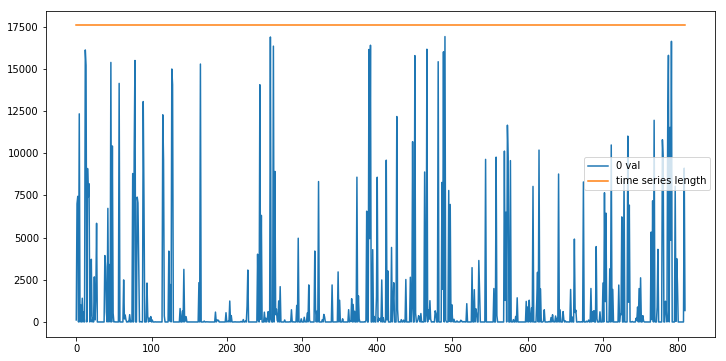

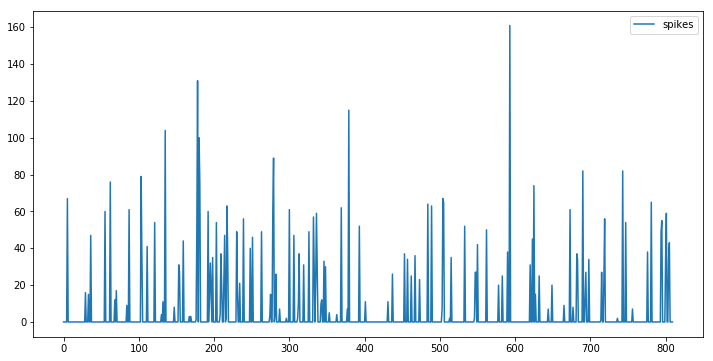

In [7]:
list_len = []
list_0val = []
list_spikes = np.zeros(len(time_series_wiki))
count = 0
for k in range(len(time_series_wiki)):
    ts = time_series_wiki[k]
    #print(k, 'length= ', len(ts), 'zero/NAN values = ', (ts == 0).sum())
    #print(ts.std())
    #print(ts.mean())
    list_len.append(len(ts))
    list_0val.append((ts == 0).sum())
    
    #list_spikes.append(((ts > (ts.mean() + 5*ts.std())) & (ts.std()/ts.mean() < 3)).sum())
    val = ((ts > (ts.mean() + 5*ts.std())) & (ts.std()/ts.mean() < 1)).sum()
    list_spikes[k] = val
    if val > 200:
        print('spikes ', val)
    if (ts == 0).sum()/len(ts) > 0.1:
        count += 1
# print(count)    
plt.figure(figsize=(12, 6))
plt.plot(list_0val, label='0 val')
plt.plot(list_len, label='time series length')
plt.legend(loc='best')

plt.figure(figsize=(12,6))
plt.plot(list_spikes, label = 'spikes')
plt.legend(loc = 'best')

### Time series decomposition: seasonality, trend, residual

In [8]:
# time series decomposition: a mutiplicative approach, better suits the current data
def ts_decomposition(ts, window):
    import pandas as pd
    from statsmodels.tsa.seasonal import seasonal_decompose
    result = seasonal_decompose(ts, model='multiplicative', freq=window)
    plt.figure()
    result.plot()
    plt.show()

Let's look at the Trend/Seasonal/Residual components of the data, use window = day

<Figure size 432x288 with 0 Axes>

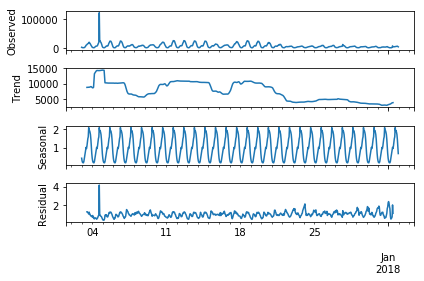

In [9]:
ts_decomposition(time_series_wiki[644][-month:],day)

## Discrete Fourier Transform visualize
#### Let's look at the domaniant frequency of the input time series. Here I converted the frequncy into cycles: cyc = freq * window. For example, in window = 24, we can see how the pattern repeats itself per (*) day.

In [10]:
# discrete Fourier transform with FFT
def discrete_ft(x,window):
    # important variables are written explicitly
    y = x.values # signal

    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range

    # we only keep the positive frequency up to the Nyquist = 2*Fs
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(x)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('network traffic')
    ax[1].plot(cycle,abs(Y),'r') # plotting the spectrum
    ax[1].set_xlabel('cycles per '+str(window)+' hours')
    ax[1].set_ylabel('network frequency spectrum')

## Time series characterization with DFT
Give a comphrehensive score for any time series!

[trend, halfDay, Day, Week, Month, spike, 'Strongest Characteristic', mean, standard dev]

Based on this score, we will know/plot/calculate/... the statistics of the entire given input dataset.

How it works:
1. the <b>location</b> of the frequency peak indicates whether it's periodic / trend / random noise, a few examples:

Time: seasonality with period T --> Freq: peak at 1/T (and should > the smallest freq to separate it from the zero freq component), half day seasonality peak at 2, day peak at 1, week peak at ~0.143, month peak at ~ 0.033, etc

Time: trend or gaussian pulse --> Freq: peak at ~0 with vary fast decay, typically diminishes around ~0.01 in this case

Time: constant signal --> Freq: zero frequency component

Time: random noise with constant mean --> Freq: random noise

Time: delta(x-x0) --> Freq: e^-i2pi(x-x0)k

2. the <b>amplitude</b> of the peak relfects how *strong* this characteristic is.


3. then, the time series gets label of it's largest normalized characteristic


4. the characteristic score: if it shows such char, it gets a score (normalized amp); if it doesn't show such char, it gets a 0 score in this category

In [13]:
import heapq
def characterize_ts(ts,window):
    y = ts.values # signal
    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    # we only keep the positive frequency up to the Nyquist = 1/(2*dT), dT = sampling interval
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half
    yabs = np.abs(Y)
    
    # locate the largest 15 peaks, use them to characterise the time series
    indx = heapq.nlargest(15, range(len(yabs)), yabs.__getitem__)
    amp = heapq.nlargest(15,yabs)

    mean = yabs.mean()
    std = yabs.std()
    cyc_hday = 2.0
    cyc_day = cyc_hday / 2.0
    cyc_week = cyc_day / 7.0
    cyc_month = cyc_day / 30.0

    comp = lambda a,b : np.abs(a/b - 1) < 0.05
    ts_type = ['trend', 'halfDay', 'Day', 'Week', 'Month', 'spike']
    report_list = [0] * 8
    for counter, value in enumerate(indx):
        # define a peak in frequency domain
        if amp[counter] > (mean + 3*std):
            amp_norm = (amp[counter] - mean)/std
            if cycle[value] < 0.01:
                # trend (increasing, decreasing, gaussian pulse)
                report_list[0] = max(amp_norm,report_list[0])
            elif comp(cycle[value], cyc_hday):
                report_list[1] = max(amp_norm,report_list[1])
            elif comp(cycle[value], cyc_day):
                report_list[2] = max(amp_norm,report_list[2])
            elif comp(cycle[value], cyc_week):
                report_list[3] = max(amp_norm,report_list[3])
            elif comp(cycle[value], cyc_week):
                report_list[4] = max(amp_norm,report_list[4])

    if sum(report_list[:4]) > 0:
        index = report_list[:4].index(max(report_list[:4])) 
        report_list[5] = ts_type[index]
    else: 
        report_list[5] = ts_type[-1:]

    report_list[-2] = y.mean()
    report_list[-1] = y.std()
    return report_list

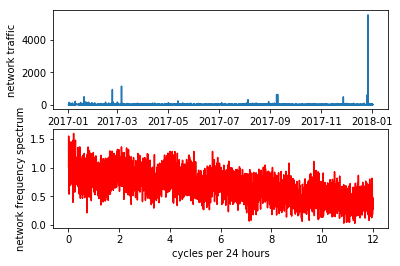

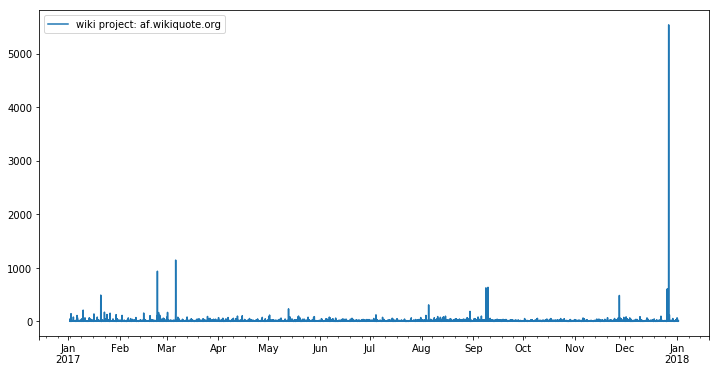

[3.4715314791922274, 0, 0, 3.012134609801039, 0, 'trend', 10.746917808219179, 68.32052105923981]


In [14]:
pick = 10
discrete_ft(time_series_wiki[pick][-year:],day)
report = characterize_ts(time_series_wiki[pick][-year:],day)
plt.figure(figsize=(12, 6))
time_series_wiki[pick][-year:].plot(label='wiki project: ' + wp_list[pick])
plt.legend()
plt.show()
print(report)

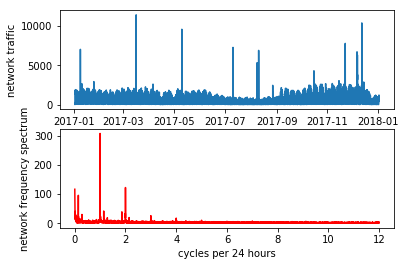

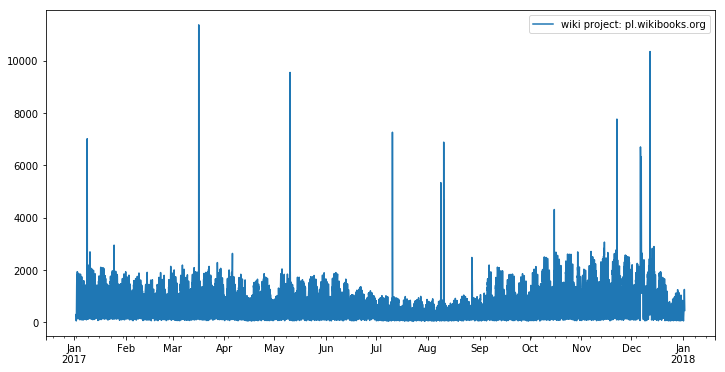

[17.885450271786624, 18.813161855506095, 48.01086383400096, 14.608292188329038, 0, 'Day', 888.2334474885845, 663.5214649347907]


In [15]:
pick = 547
discrete_ft(time_series_wiki[pick][-year:],day)
report = characterize_ts(time_series_wiki[pick][-year:],day)
plt.figure(figsize=(12, 6))
time_series_wiki[pick][-year:].plot(label='wiki project: ' + wp_list[pick])
plt.legend()
plt.show()
print(report)

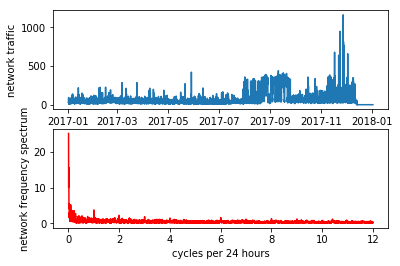

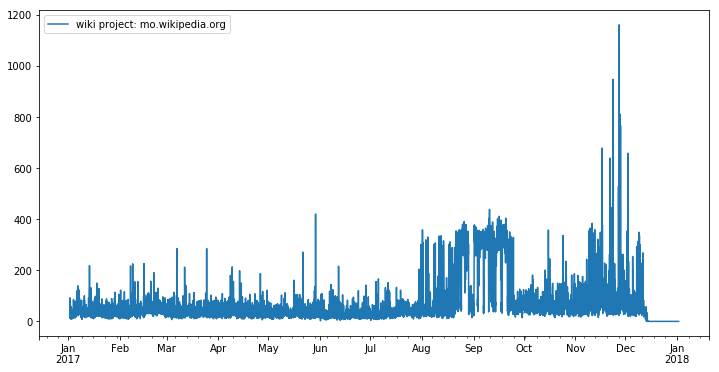

[34.20200159122759, 0, 4.517957345641338, 0, 0, 'trend', 65.10593607305935, 81.56974051388642]


In [16]:
pick = 465
discrete_ft(time_series_wiki[pick][-year:],day)
report = characterize_ts(time_series_wiki[pick][-year:],day)
plt.figure(figsize=(12, 6))
time_series_wiki[pick][-year:].plot(label='wiki project: ' + wp_list[pick])
plt.legend()
plt.show()
print(report)